In [1]:
import numpy as np

from gwbench import network

import scipy.stats as stats
from scipy import integrate


import bilby

In [2]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "serif",
    "font.size": 14
})

%config InlineBackend.figure_format='retina' # very useful command for high-res images


In [3]:
def inner_prod_simps_normed(h1, h2, Sn, f, h1_norm = None, h2_norm=None):
    if h1_norm is None:
        h1_norm = 4*np.real(integrate.simpson(y= h1*np.conjugate(h1) / Sn, x=f))
    if h2_norm is None:
        h2_norm = 4*np.real(integrate.simpson(y= h2*np.conjugate(h2) / Sn, x=f))
    return  2*np.real(integrate.simpson(y= (h1*np.conjugate(h2) + h2*np.conjugate(h1)) / Sn, x=f)) / (np.sqrt(h1_norm * h2_norm))

def inner_prod_simps(h1, h2, Sn, f):
    return  2*np.real(integrate.simpson(y= (h1*np.conjugate(h2) + h2*np.conjugate(h1)) / Sn, x=f))

def cutler_vallisneri_overlap_vec(del_hf, delta_hf, psd, freqs):
    return np.array([ inner_prod_simps(del_hf[deriv], delta_hf, psd, freqs) for deriv in del_hf ])

In [4]:
import glob
import pandas as pd

files = glob.glob1('powerlaw_smooth_hybrid_3G_production/', 'hybr_0.0*')
print(files)

df = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv('powerlaw_smooth_hybrid_3G_production/'+fi)
    df = pd.concat([df,df_temp])
# drop the zero rows that resulted from NoneType Networks
df = df.loc[~(df==0).all(axis=1)]

print(len(df[(df["hybr"]==0.0)]))

['hybr_0.0_0_20000.csv', 'hybr_0.0_20000_40000.csv', 'hybr_0.0_60000_80000.csv', 'hybr_0.0_40000_60000.csv', 'hybr_0.0_80000_100000.csv']
97191


In [5]:
labels = {
    'Mc': '$\mathcal{M}_c$',
    'eta': '$\eta$',
    'chi1z': '$\chi_{1,\\rm z}$',
    'chi2z': '$\chi_{2, \\rm z}$',
    'DL': '$D_{\\rm L}$',
    'z': '$z \;\;\;\;\;\;$',
    'm1_det': '$m_{1, \\rm det}$',
    'm2_det': '$m_{2, \\rm det}$',
    'm1_src': '$m_{1, \\rm src}$',
    'm2_src': '$m_{2, \\rm src}$',
    'chi_eff': '$\chi_{\\rm eff}$',
    'ra': 'ra',
    'dec': 'dec',
    'psi': 'psi',
    'iota': 'iota',
    'q': '$q \;\;\;\;\;\;\,$',
    'm_tot': '$M_{\\rm total}$'
}

# Set up Binary

In [6]:
input_file = 'smooth_powerlaw_pop.npz'
with np.load(input_file, mmap_mode='r') as binaries:
    Mcs = np.array(binaries['Mcs'])
    etas = np.array(binaries['etas'])
    chi1z = np.array(binaries['chi1z'])
    chi2z = np.array(binaries['chi2z'])
    DLs = np.array(binaries['DLs'])
    iotas = np.array(binaries['iotas'])
    ras = np.array(binaries['ras'])
    decs = np.array(binaries['decs'])
    psis = np.array(binaries['psis'])

In [7]:
index_golden = 54837
index_typical = 21985
index_optimistic = 78736
index_pessimistic = 47519

index_mass_gap = 73505

In [81]:
i = index_pessimistic

network_spec = ['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']

approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

inj_params = {
    'Mc':    Mcs[i],
    'eta':   etas[i],
    'chi1x': 0.,
    'chi2x': 0.,
    'chi1y': 0.,
    'chi2y': 0.,
    'chi1z': chi1z[i],
    'chi2z': chi2z[i],
    'DL':    DLs[i],
    'tc':    0.,
    'phic':  0.,
    'iota':  iotas[i],
    'ra':    ras[i],
    'dec':   decs[i],
    'psi':   psis[i],
    # 'gmst0': bilby.gw.utils.greenwich_mean_sidereal_time(0.),
    'gmst0': 0.
} 

d_f = 2**-4
f_low = 5.
f_high = 2048.
f = np.arange(f_low, f_high, d_f)
 
deriv_symbs_string = 'Mc eta DL chi1z chi2z tc phic iota ra dec psi'
deriv_variables = ['Mc', 'eta', 'DL', 'chi1z', 'chi2z', 'tc', 'phic', 'iota', 'ra', 'dec', 'psi']

In [82]:
net_ap = network.Network(network_spec=network_spec)

approximant = 'IMRPhenomD'
wf_model_name = 'lal_bbh'
# pass the chosen waveform to the network for initialization
net_ap.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})


use_rot = 0

net_ap.set_net_vars(
    f=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    use_rot=use_rot
    )
net_ap.calc_wf_polarizations()
net_ap.calc_wf_polarizations_derivs_num(step=1e-9, method='central', order=2, n=1)
net_ap.setup_ant_pat_lpf_psds()
net_ap.calc_det_responses()
net_ap.calc_det_responses_derivs_num(step=1e-9, method='central', order=2, n=1)
net_ap.calc_snrs()
net_ap.calc_errors()


net_tr = network.Network(network_spec=network_spec)

approximant = 'IMRPhenomXAS'
wf_model_name = 'lal_bbh'
# pass the chosen waveform to the network for initialization
net_tr.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})

net_tr.set_net_vars(
    f=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    use_rot=use_rot
    )
net_tr.calc_wf_polarizations()
net_tr.setup_ant_pat_lpf_psds()
net_tr.calc_det_responses()
net_tr.calc_snrs()

2024-01-12 12:06:45,097 - Network - INFO : Polarizations calculated.
2024-01-12 12:06:45,099 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-12 12:06:45,105 - Network - INFO : Polarizations calculated.
2024-01-12 12:06:50,777 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-12 12:06:50,833 - Network - INFO : PSDs loaded.
2024-01-12 12:06:50,839 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-12 12:06:50,854 - Network - INFO : Detector responses calculated.
2024-01-12 12:06:50,855 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-12 12:06:50,856 - Network - INFO :    CE-40_C
2024-01-12 12:06:54,490 - Network - INFO :    CE-20_S
2024-01-12 12:06:58,093 - Network - INFO :    ET_ET1
2024-01-12 12:07:01,668 - Network - INFO :    ET_ET2
2024-01-12 12:07:05,245 - Network - INFO :    ET_ET3
2024-01-12 12:07:08,869 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-12 1

# Impose prior bounds on $\chi$ errors

In [83]:
from gwbench import fisher_analysis_tools as fat

In [84]:
chi1_idx = net_ap.deriv_variables.index('chi1z')
chi2_idx = net_ap.deriv_variables.index('chi2z')

chi_prior_range = 1.0

fisher_bounds = np.zeros_like(net_ap.fisher)
fisher_bounds[chi1_idx,chi1_idx] = 1.0/chi_prior_range**2
fisher_bounds[chi2_idx,chi2_idx] = 1.0/chi_prior_range**2

net_ap_fisher_reg = net_ap.fisher + fisher_bounds

cov_reg = np.linalg.inv(net_ap_fisher_reg)
cov_reg   = (cov_reg + cov_reg.T) / 2

errs = fat.get_errs_from_cov(cov_reg,net_ap.deriv_variables)
errs

{'Mc': 0.005417378016245389,
 'eta': 0.00121442465039939,
 'DL': 86.24807270133444,
 'chi1z': 0.6694709768405755,
 'chi2z': 0.6881654287769424,
 'tc': 0.0005516224335494837,
 'phic': 0.09481048309775628,
 'iota': 0.030146165430969003,
 'ra': 0.0028130727384407224,
 'dec': 0.00306702791844742,
 'psi': 0.04577436068037907}

# Compute CV Bias

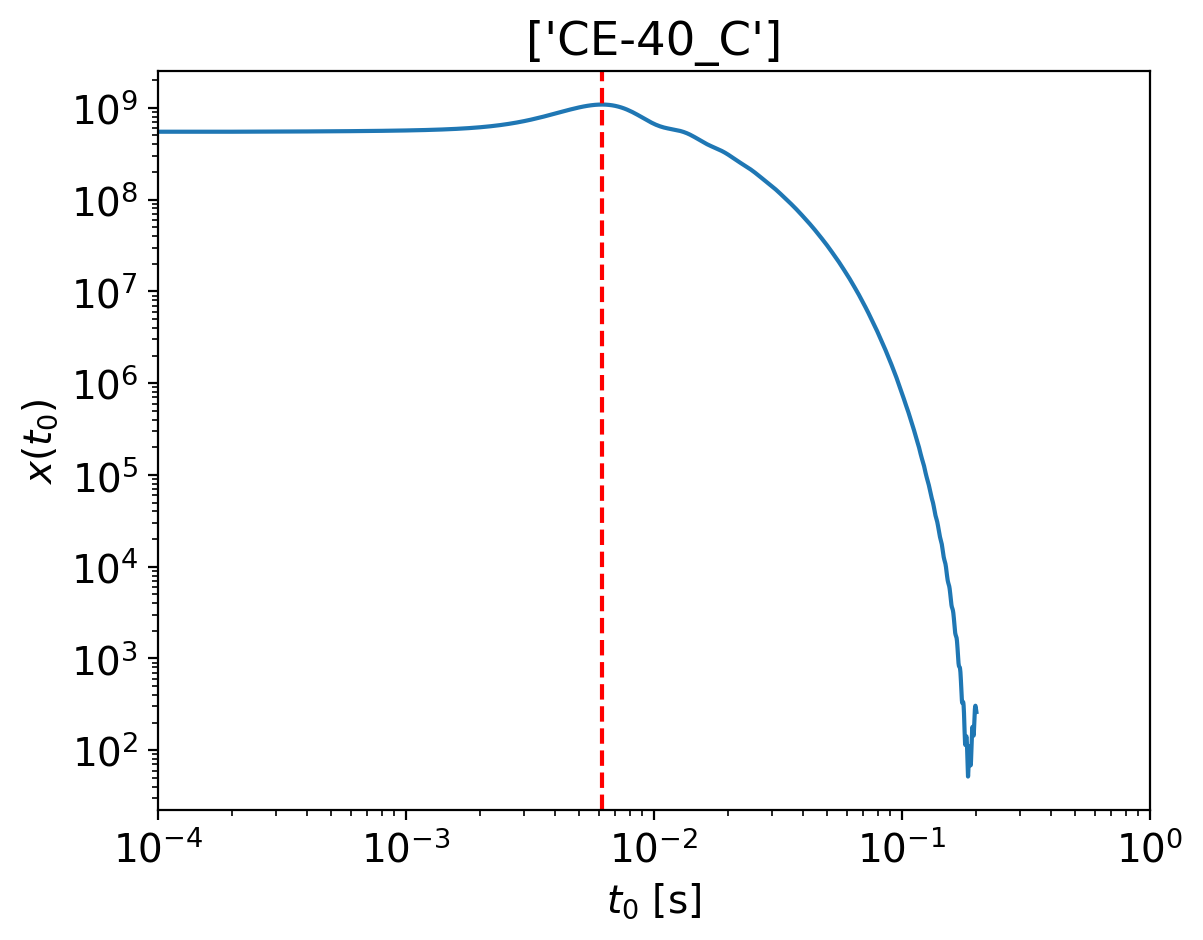

2024-01-12 12:07:12,033 - Network - INFO : Polarizations calculated.
2024-01-12 12:07:12,040 - Network - INFO : PSDs loaded.
2024-01-12 12:07:12,042 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-12 12:07:12,048 - Network - INFO : Detector responses calculated.
2024-01-12 12:07:12,053 - Network - INFO : Polarizations calculated.


time shift: 0.006200000000000001
phase shift: -2.180967149089699
Inner product:
0.9997099060535213


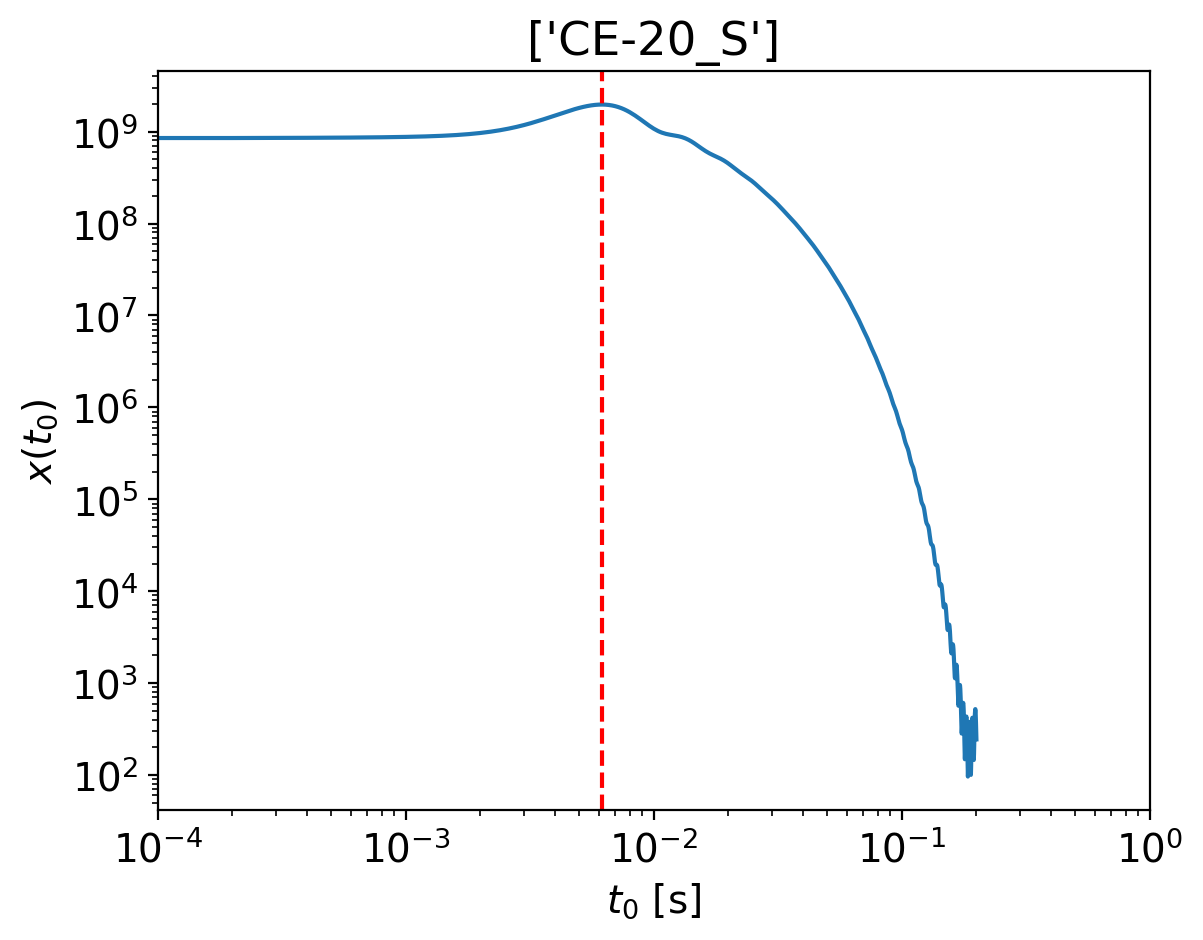

2024-01-12 12:07:14,254 - Network - INFO : Polarizations calculated.
2024-01-12 12:07:14,261 - Network - INFO : PSDs loaded.
2024-01-12 12:07:14,263 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-12 12:07:14,268 - Network - INFO : Detector responses calculated.
2024-01-12 12:07:14,273 - Network - INFO : Polarizations calculated.


time shift: 0.006200000000000001
phase shift: -2.181984760602159
Inner product:
0.9996440446772952


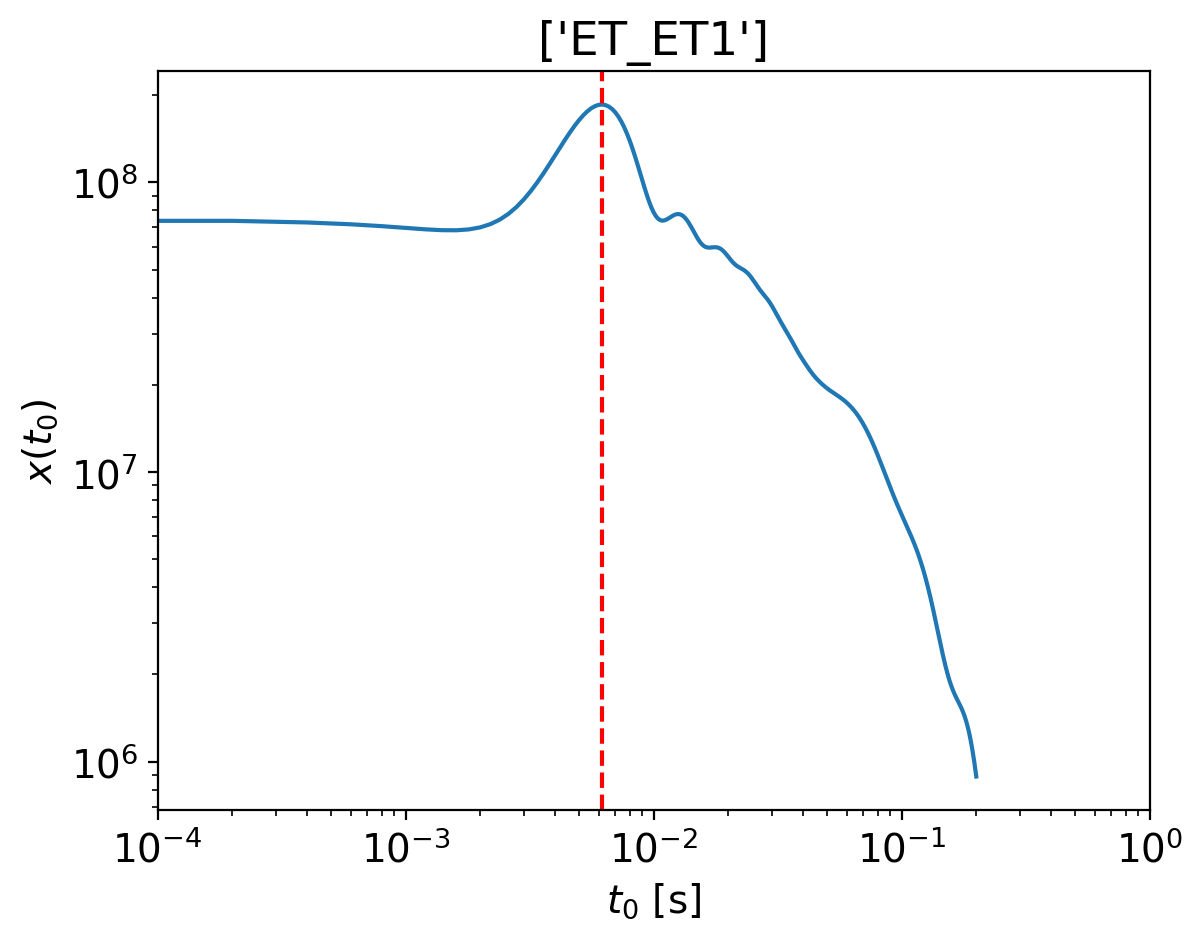

2024-01-12 12:07:16,722 - Network - INFO : Polarizations calculated.
2024-01-12 12:07:16,738 - Network - INFO : PSDs loaded.
2024-01-12 12:07:16,739 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-12 12:07:16,745 - Network - INFO : Detector responses calculated.
2024-01-12 12:07:16,750 - Network - INFO : Polarizations calculated.


time shift: 0.006200000000000001
phase shift: -2.1774378153598883
Inner product:
0.9995827422534909


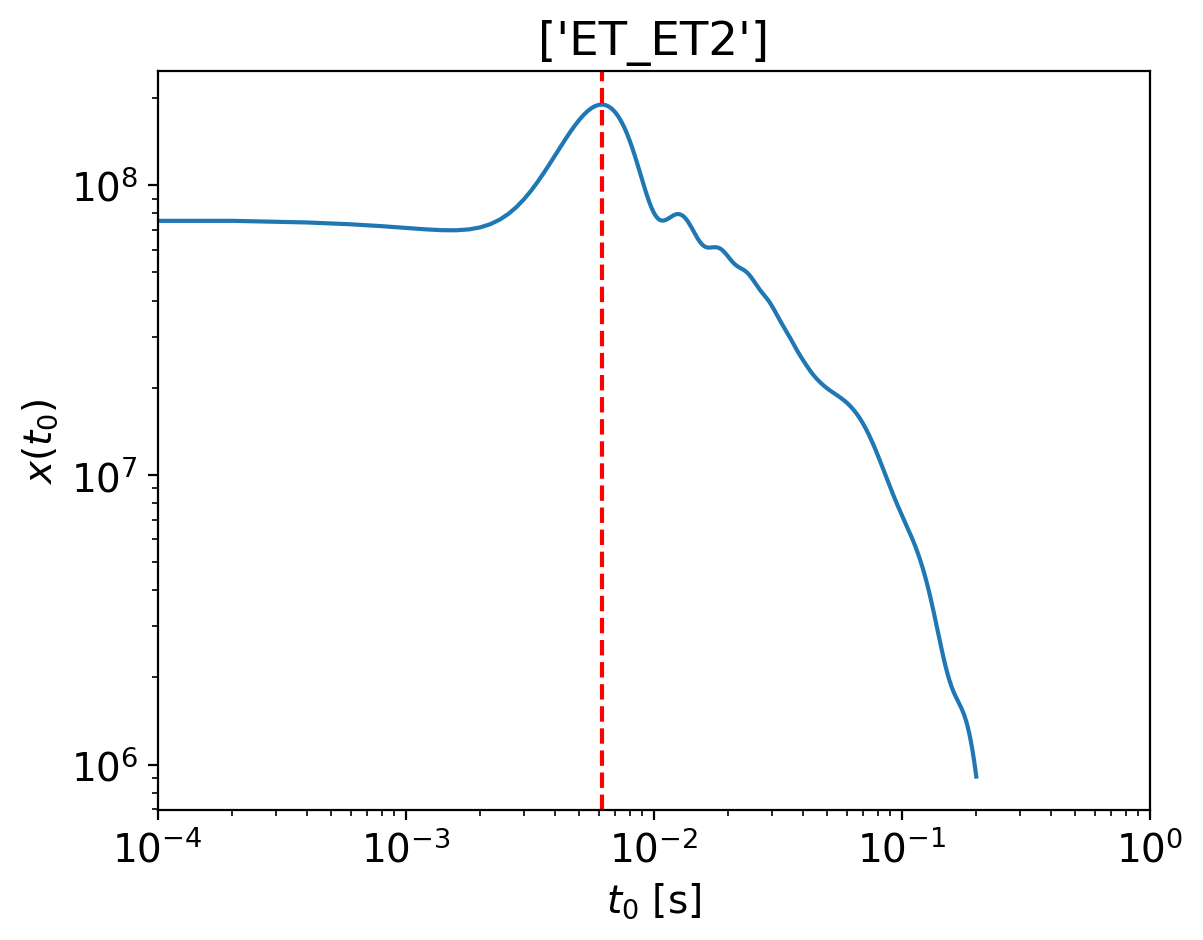

2024-01-12 12:07:19,216 - Network - INFO : Polarizations calculated.
2024-01-12 12:07:19,232 - Network - INFO : PSDs loaded.
2024-01-12 12:07:19,235 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-12 12:07:19,240 - Network - INFO : Detector responses calculated.
2024-01-12 12:07:19,245 - Network - INFO : Polarizations calculated.


time shift: 0.006200000000000001
phase shift: -2.1774378153598883
Inner product:
0.9995827422534909


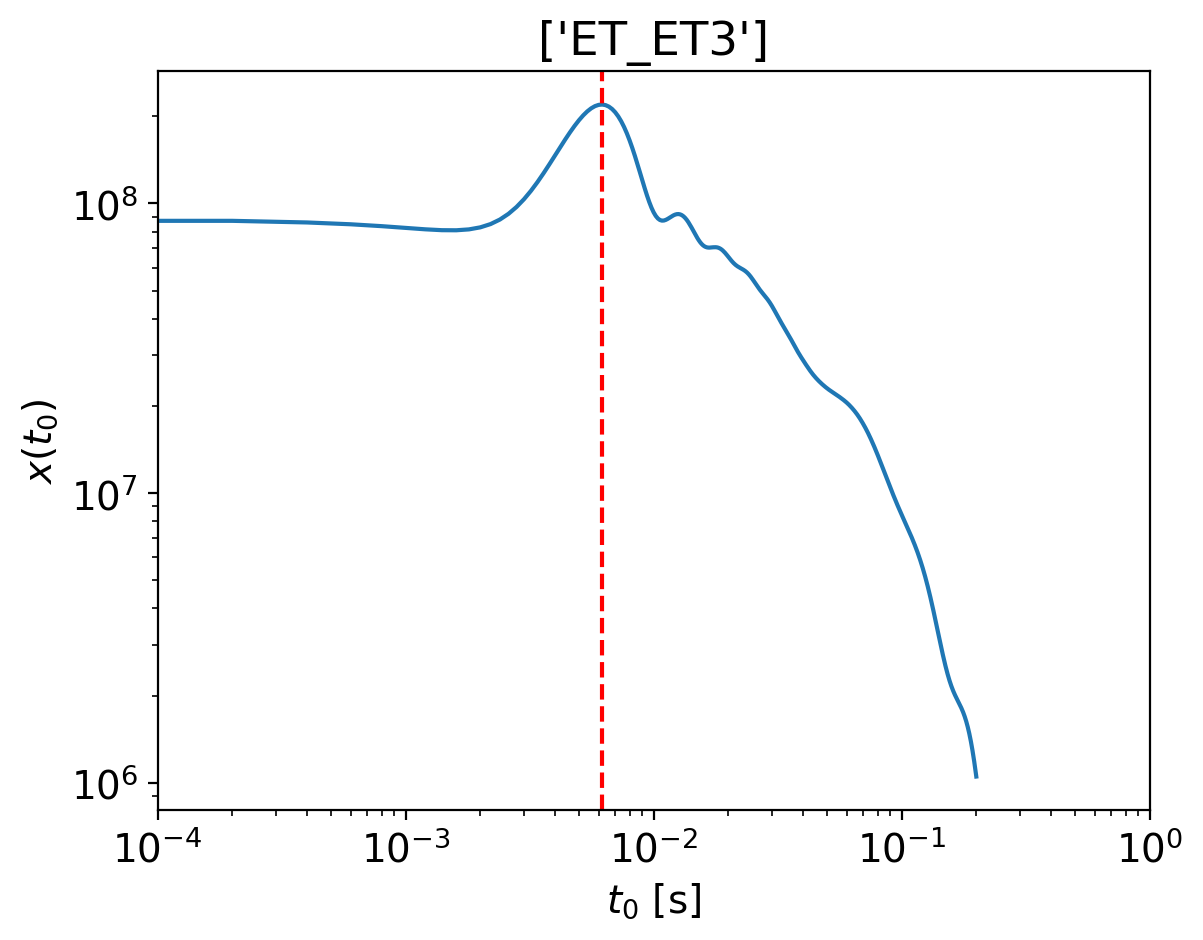

2024-01-12 12:07:21,887 - Network - INFO : Polarizations calculated.
2024-01-12 12:07:21,900 - Network - INFO : PSDs loaded.
2024-01-12 12:07:21,902 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-12 12:07:21,908 - Network - INFO : Detector responses calculated.
2024-01-12 12:07:21,913 - Network - INFO : Polarizations calculated.


time shift: 0.006200000000000001
phase shift: -2.1774378153598883
Inner product:
0.9995827422534909


In [85]:
overlap_vecs_network = np.zeros((len(net_ap.detectors), len(net_ap.deriv_variables)))

time_arr_d = np.linspace(0.0, 0.2, 1001)

for d in range(len(net_ap.detectors)):

    ## set up initial waveforms
    h1 = net_tr.detectors[d].hf
    h2 = net_ap.detectors[d].hf
    f = net_ap.detectors[d].f
    Sn = net_ap.detectors[d].psd
    network_spec_d = [net_ap.detectors[d].det_key]

    x_t0_re_d = np.zeros(len(time_arr_d))
    x_t0_im_d = np.zeros(len(time_arr_d))

    for i in range(len(time_arr_d)):
        t0 = time_arr_d[i]
        x_t0_d = 4*(integrate.simpson(h1 * np.conjugate(h2) * np.exp(2*np.pi*1j*f*t0)/ Sn, x=f))
        x_t0_re_d[i] = np.real(x_t0_d)
        x_t0_im_d[i] = np.imag(x_t0_d)

    max_idx = np.argmax(x_t0_re_d**2 + x_t0_im_d**2)
    time_shift_d = time_arr_d[max_idx]
    phase_shift_d = (np.angle(x_t0_re_d + 1j*x_t0_im_d))[max_idx]

    plt.title(network_spec_d)
    plt.plot(time_arr_d, x_t0_re_d**2 + x_t0_im_d**2)
    plt.axvline(x=time_shift_d, ls='--', c='r')
    plt.xlabel('$t_0$ [s]')
    plt.ylabel("$x(t_0)$")
    plt.loglog()
    plt.xlim(1e-4, 1e0)
    plt.show()
    print("time shift:", time_shift_d)
    print("phase shift:", phase_shift_d)

    inj_params_opt_d = inj_params.copy()
    inj_params_opt_d['tc'] = time_shift_d # should be positive when shifting XAS to maximize overlap
    inj_params_opt_d['phic'] = phase_shift_d  # should be positive when shifting XAS to maximize overlap
 

    net_tr_opt_d = network.Network(network_spec=network_spec_d)
    net_tr_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomXAS'})
    net_tr_opt_d.set_net_vars(
        f=f, inj_params=inj_params_opt_d,
        deriv_symbs_string=deriv_symbs_string,
        use_rot=use_rot
        )
    net_tr_opt_d.calc_wf_polarizations()
    net_tr_opt_d.setup_ant_pat_lpf_psds()
    net_tr_opt_d.calc_det_responses()
    net_tr_opt_d.calc_wf_polarizations()

    print("Inner product:")
    print(inner_prod_simps_normed(net_ap.detectors[d].hf, net_tr_opt_d.detectors[0].hf, net_ap.detectors[d].psd, net_ap.detectors[d].f))


    ## Compute CV overlap vector for this detector
    delta_hf = net_tr_opt_d.detectors[0].hf - net_ap.detectors[d].hf
    overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap.detectors[d].del_hf, delta_hf, net_ap.detectors[d].psd, net_ap.detectors[d].f)

# cv_bias_opt = np.matmul(net_ap.cov, np.sum(overlap_vecs_network, axis=0))
# cv_bias_opt = np.array(cv_bias_opt.tolist()[0])

cv_bias_opt = np.matmul(cov_reg, np.sum(overlap_vecs_network, axis=0))
cv_bias_opt = np.array(cv_bias_opt.tolist())

In [86]:
cv_bias_opt_dict = {}

for i, param in enumerate(net_ap.deriv_variables):
    cv_bias_opt_dict[param] = cv_bias_opt[i]

cv_bias_opt_dict

{'Mc': -0.02219378238960057,
 'eta': 0.0010935932821416472,
 'DL': 59.088724882445604,
 'chi1z': 0.8630518871946151,
 'chi2z': -0.8956068004954432,
 'tc': -0.00033064397264181977,
 'phic': -0.06043526085734641,
 'iota': -0.019805754107577345,
 'ra': -0.00027761179316163065,
 'dec': -0.0005860658144850872,
 'psi': -0.038393291646983574}

# Plots

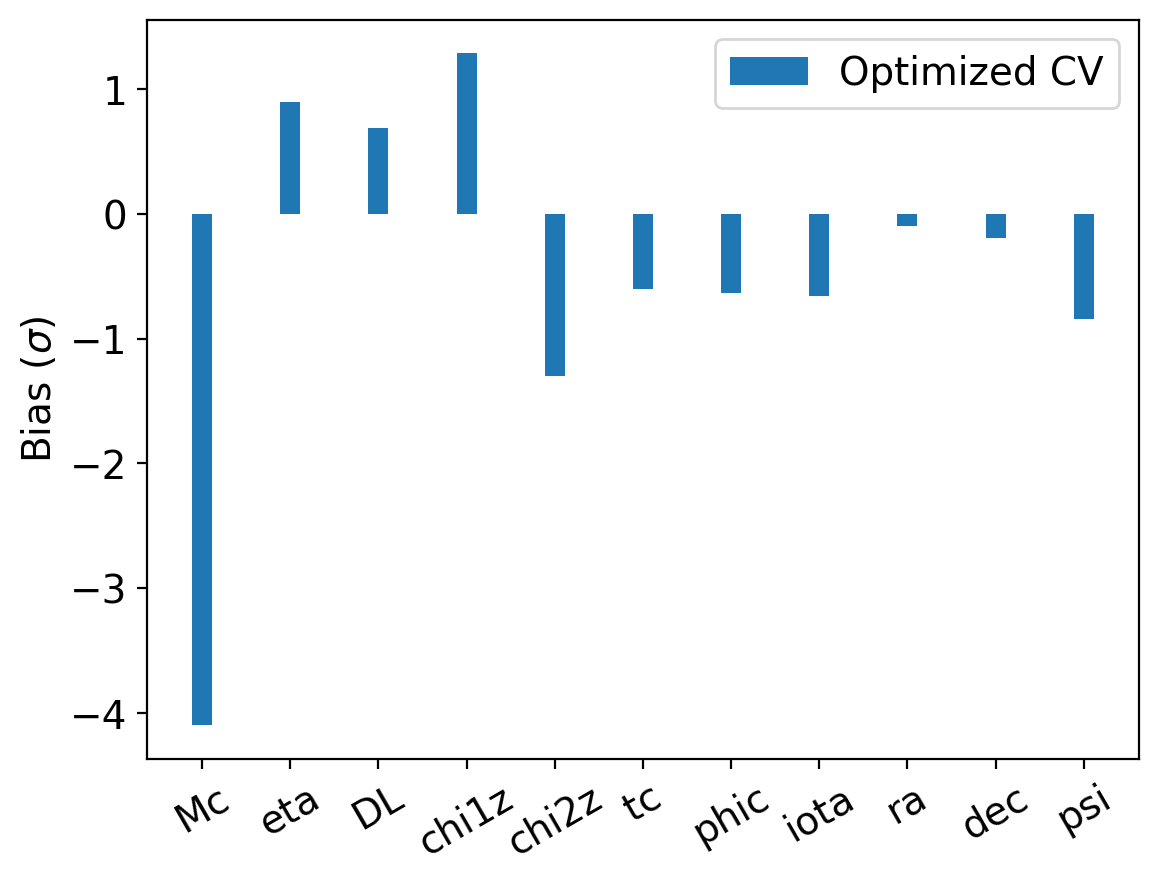

Mc, 1: -4.097 sigma

eta, 1: 0.901 sigma

DL, 1: 0.685 sigma

chi1z, 1: 1.289 sigma

chi2z, 1: -1.301 sigma

tc, 1: -0.599 sigma

phic, 1: -0.637 sigma

iota, 1: -0.657 sigma

ra, 1: -0.099 sigma

dec, 1: -0.191 sigma

psi, 1: -0.839 sigma



In [87]:
cv_bias_opt_sigma = np.zeros(len(cv_bias_opt))

for i, param in enumerate(net_ap.deriv_variables):
    # cv_bias_opt_sigma[i] = cv_bias_opt_dict[param]/net_ap.errs[param]
    cv_bias_opt_sigma[i] = cv_bias_opt_dict[param]/errs[param]


bias1 = cv_bias_opt_sigma
# bias2 = pe_bias

x = np.linspace(0, len(bias1), len(bias1))

width = 0.25
plt.bar(x, bias1, width=width, label='Optimized CV')
# plt.bar(x+width, bias2, width=width, label="PE")

plt.xticks(x, deriv_variables, rotation=30)
plt.ylabel('Bias ($\sigma$)')
plt.legend()
plt.show()

for i, param in enumerate(deriv_variables):
    print(f"{param}, 1: {bias1[i]:.3f} sigma")
    # print(f"{param}, 2: {bias2[i]:.3f} sigma")
    print()

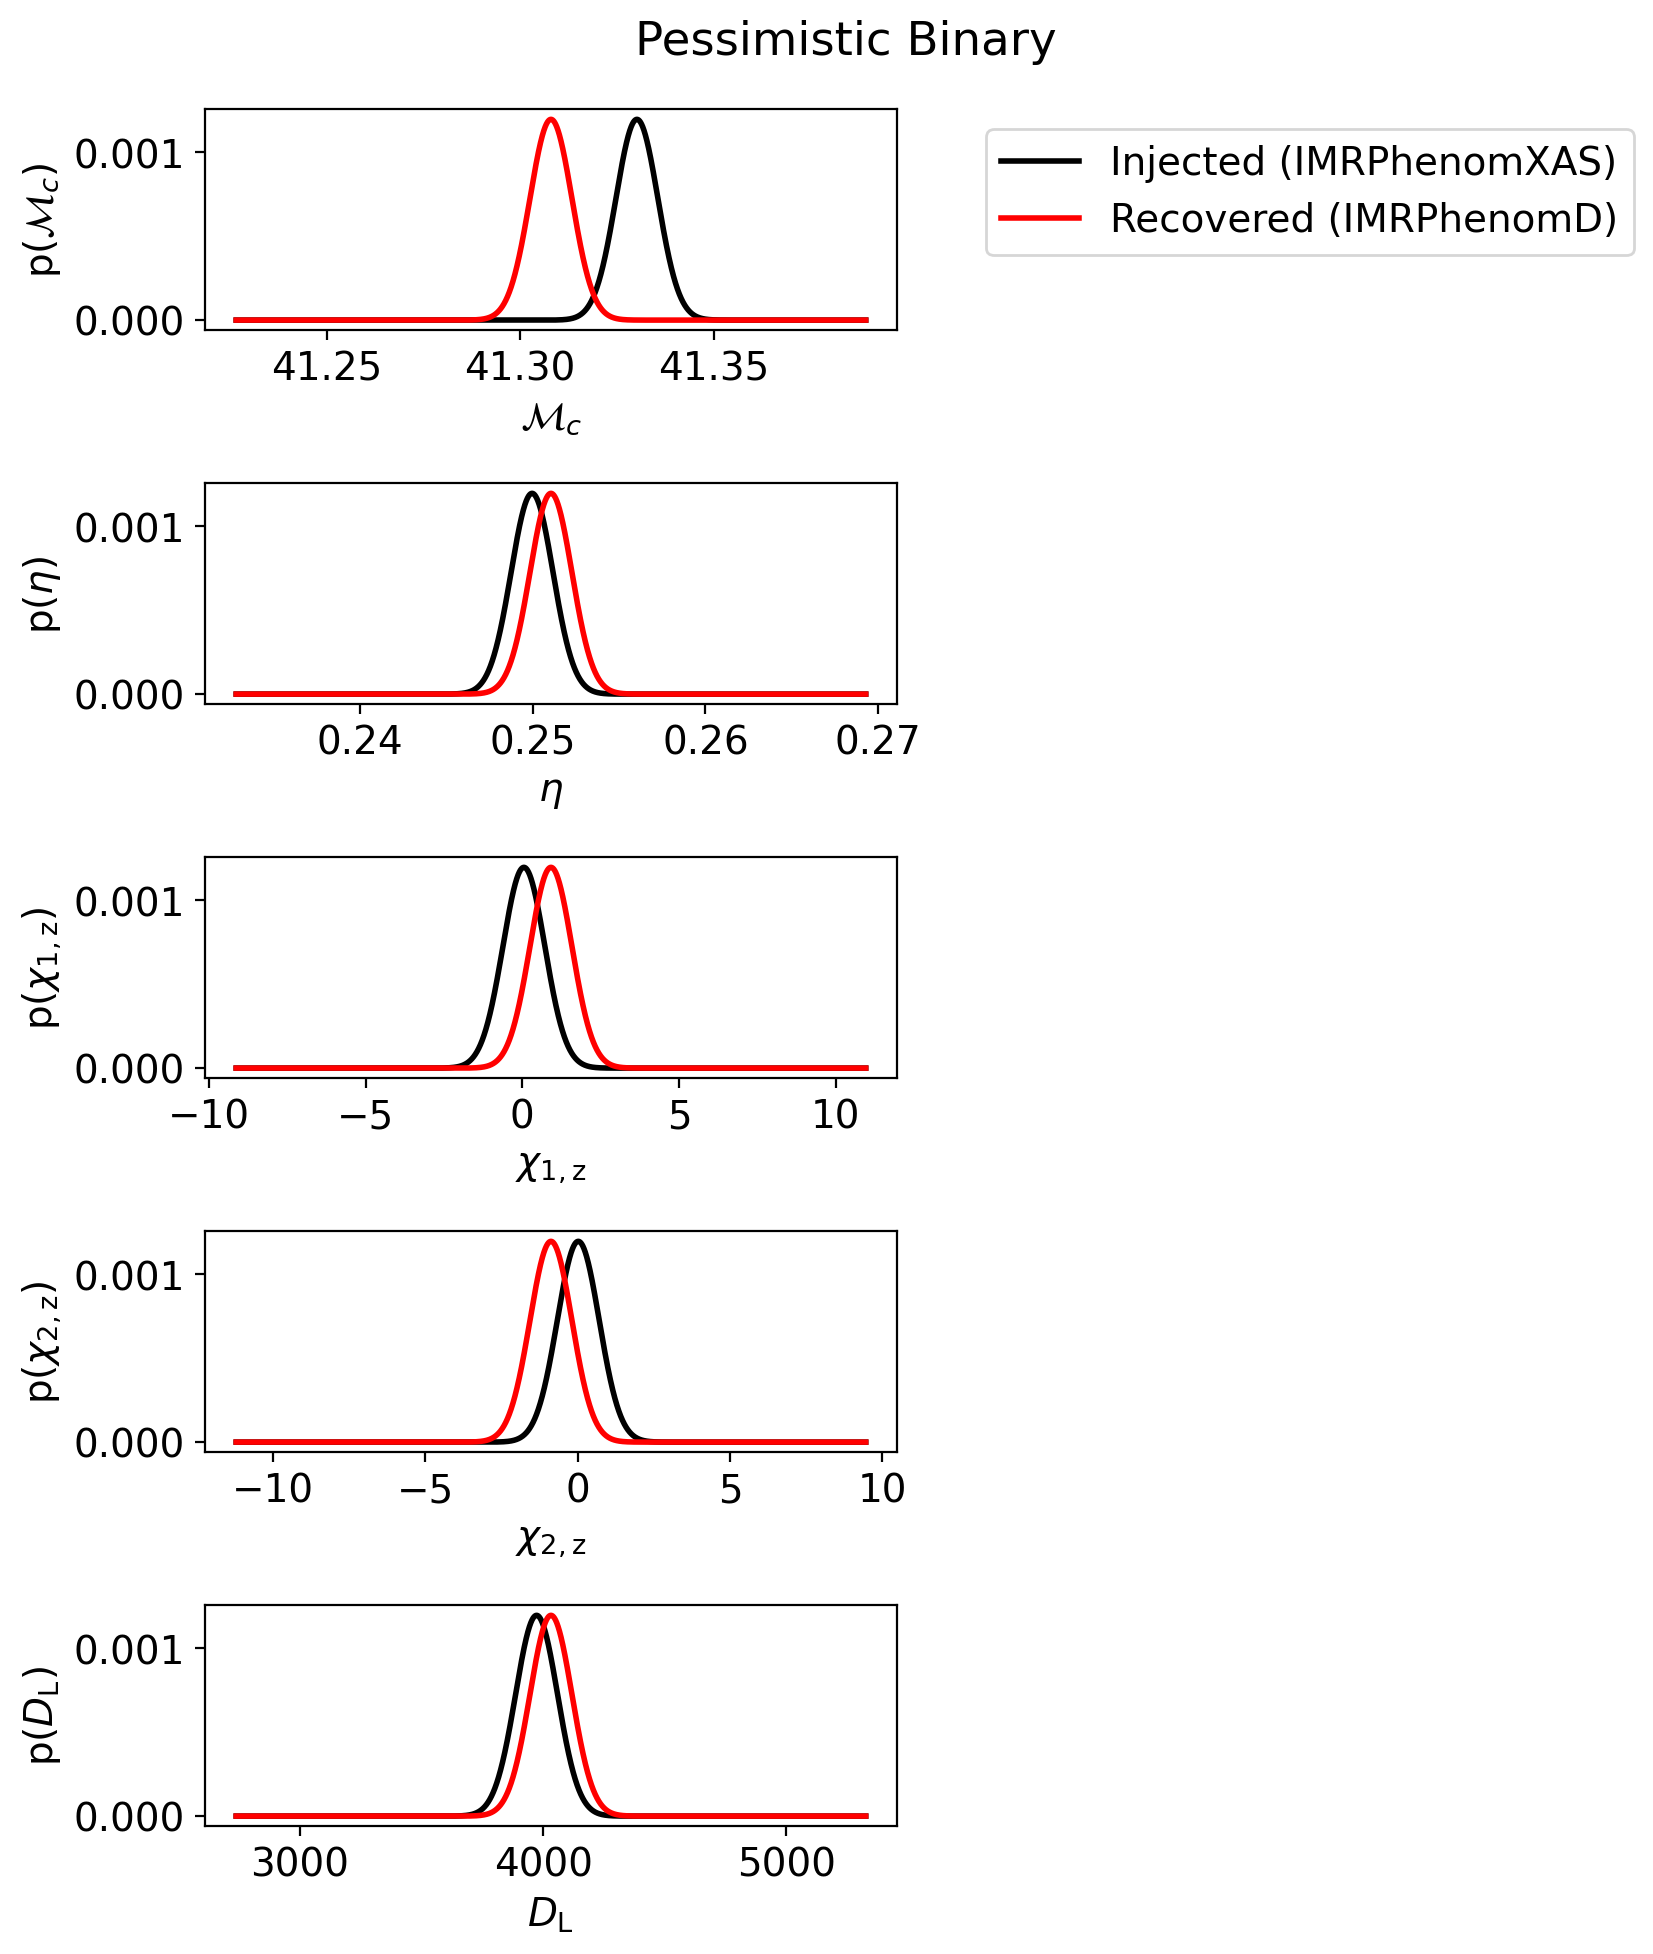

In [88]:
title = "Pessimistic Binary"
vars=['Mc', 'eta', 'chi1z', 'chi2z', 'DL']

fig, axes = plt.subplots(ncols=1, nrows=len(vars), figsize=(9, 2*len(vars)))
ax = list(axes)

for i, param in enumerate(vars):
    mu = net_ap.inj_params[param]
    # sigma = net_ap.errs[param]
    sigma = errs[param]
    bias = cv_bias_opt_dict[param]

    x = np.linspace((mu+bias)-15*sigma, (mu+bias)+15*sigma, 10000)

    inj_est = stats.norm.pdf(x, mu, sigma)
    inj_est = inj_est/np.sum(inj_est)

    biased_est = stats.norm.pdf(x, mu+bias, sigma)
    biased_est = biased_est/ np.sum(biased_est)


    ax[i].plot(x, inj_est, label=f"Injected (IMRPhenomXAS)", color='k', lw=2)
    ax[i].plot(x, biased_est, label=f"Recovered (IMRPhenomD)",color='r', lw=2)

    ax[i].set_xlabel(labels[param])
    ax[i].set_ylabel(f"p({labels[param]})")

ax[0].legend(bbox_to_anchor=(1.1, 1), fontsize=14)
plt.suptitle(title)

plt.tight_layout()
plt.show()


In [78]:
from pycbc import conversions as conv
from astropy.cosmology import Planck18, z_at_value
import astropy.units as u

In [79]:
mc = inj_params["Mc"]
eta = inj_params["eta"]
dl = inj_params["DL"]
z = z_at_value(Planck18.luminosity_distance, dl* u.Mpc).value
m1_src = conv.mass1_from_mchirp_eta(mc, eta)/(1+z)

print(f"m1_src = {m1_src:.3f}")

m1_src = 51.057


In [80]:
mc = inj_params["Mc"] + cv_bias_opt_dict["Mc"]
eta = inj_params["eta"]+ cv_bias_opt_dict["eta"]
dl = inj_params["DL"] + cv_bias_opt_dict["DL"]

z = z_at_value(Planck18.luminosity_distance, dl* u.Mpc).value
m1_src = conv.mass1_from_mchirp_eta(mc, eta)/(1+z)

print(f"m1_src_biased = {m1_src:.3f}")

m1_src_biased = 67.153
